# Model training for NFL play prediction

---

In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `mannheim_meerkats.ipynb`. 

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `mannheim_meerkats.ipynb` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780) 
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

In [1]:
# basic imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

# imports for neural network models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

In [2]:
TEAM_FEATURES = [
        'posteam_ATL', 'posteam_BAL', 'posteam_BUF', 'posteam_CAR', 'posteam_CHI', 'posteam_CIN', 'posteam_CLE', 'posteam_DAL', 'posteam_DEN', 'posteam_DET', 'posteam_GB', 
        'posteam_HOU', 'posteam_IND', 'posteam_JAX', 'posteam_KC', 'posteam_LA', 'posteam_LAC', 'posteam_LV', 'posteam_MIA', 'posteam_MIN', 'posteam_NE', 'posteam_NO', 
        'posteam_NYG', 'posteam_NYJ', 'posteam_PHI', 'posteam_PIT', 'posteam_SEA', 'posteam_SF', 'posteam_TB', 'posteam_TEN', 'posteam_WAS', 'posteam_type_home',
        'defteam_ATL', 'defteam_BAL', 'defteam_BUF', 'defteam_CAR', 'defteam_CHI', 'defteam_CIN', 'defteam_CLE', 'defteam_DAL', 'defteam_DEN', 'defteam_DET', 'defteam_GB', 
        'defteam_HOU', 'defteam_IND', 'defteam_JAX', 'defteam_KC', 'defteam_LA', 'defteam_LAC', 'defteam_LV', 'defteam_MIA', 'defteam_MIN', 'defteam_NE', 'defteam_NO', 
        'defteam_NYG', 'defteam_NYJ', 'defteam_PHI', 'defteam_PIT', 'defteam_SEA', 'defteam_SF', 'defteam_TB', 'defteam_TEN', 'defteam_WAS'
    ]
TARGET_NAME = 'yards_gained'
RANDOM_STATE=42

### General functions

In [3]:
def get_data(str):
    return pd.read_csv(f"Data/{str}_df.csv")

def split_feature_target(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    features = df_sampled.drop(TARGET_NAME, axis=1)
    target = df_sampled[TARGET_NAME]

    return features, target

def prepare_model_data(data_fraction, use_team_features, play_type = "pass", test_size=0.2):
    if(play_type != "pass" and play_type != "run"):
        raise RuntimeError('Not a valid paly type')
    
    df = get_data(play_type)

    # drop teams feature
    if(not use_team_features):
        df = df.drop(TEAM_FEATURES, axis=1)

    features, target = split_feature_target(df, data_fraction)
    
    # Split the data into training and testing sets for runs and passes
    return train_test_split(features, target, test_size=test_size, random_state=RANDOM_STATE), (features, target)

### Functions for cross validation

In [4]:
def get_pipeline():
    return

def test_model(pipeline, x_train, y_train, x_test, y_test):
    pipeline.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(x_test)

    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")
    return predictions

def visualize_predicts(y_test, predictions):
    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title('Pass Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

def test_model_k_fold(df, pipeline, data_fraction, scoring, k_folds=5):
    features, target = split_feature_target(df, data_fraction)
    
    cv_results = cross_val_predict(pipeline, features, target, cv=k_folds, scoring=scoring)
    #print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(cv_scores)}")
    #print(f"Run Model Cross-Validation Mean Squared Error: {-np.max(cv_scores)}")
    return cv_results

def estimate_hyperparams(df, pipeline, data_fraction, scoring, k_folds=5, parameters={}):
    features, target = split_feature_target(df, data_fraction)
    
    # specify the cross validation
    stratified_k_fold_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=stratified_k_fold_cv, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)

    return grid_search_estimator

Linear Regression

In [5]:
df = get_data('pass')

model = LinearRegression()
test_model_k_fold(df, model, 0.1, 'neg_root_mean_squared_error')

TypeError: cross_val_predict() got an unexpected keyword argument 'scoring'

Polynomial Regression

In [15]:
df = get_data('pass')

pipeline = Pipeline([('polynomial', PolynomialFeatures()), ('model', LinearRegression())])
#test_model_k_fold(df, pipeline, 0.1, 'neg_root_mean_squared_error')
parameters = {
    'polynomial__degree': [2, 3]
}

estimator = estimate_hyperparams(df, pipeline, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


KNN

In [12]:
model = KNeighborsRegressor()
pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
parameters = {
    'model__n_neighbors': range(2, 10)
}

estimator = estimate_hyperparams(df, pipeline, 0.5, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

results = pd.DataFrame(estimator.cv_results_)
display(results)
display(estimator.best_index_)
display(estimator.best_params_)
display(estimator.best_score_)
display(estimator.best_estimator_)

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.210912,0.007716,6.776248,0.030132,2,{'model__n_neighbors': 2},-5.403603,-5.410427,-5.441620,-5.418550,0.016549,8
1,0.211860,0.000982,6.786153,0.071278,3,{'model__n_neighbors': 3},-5.156546,-5.179603,-5.204985,-5.180378,0.019783,7
2,0.210987,0.001360,6.779036,0.041510,4,{'model__n_neighbors': 4},-5.051272,-5.088301,-5.097292,-5.078955,0.019916,6
3,0.216554,0.001639,6.727051,0.040339,5,{'model__n_neighbors': 5},-5.016721,-5.047392,-5.042975,-5.035696,0.013538,5
4,0.210238,0.002190,6.786152,0.083349,6,{'model__n_neighbors': 6},-5.005372,-5.022433,-5.023339,-5.017048,0.008264,2
5,0.210509,0.002990,6.805473,0.046364,7,{'model__n_neighbors': 7},-4.999506,-5.020146,-5.028904,-5.016185,0.012324,1
6,0.212755,0.001576,6.791518,0.032909,8,{'model__n_neighbors': 8},-5.006301,-5.021917,-5.038567,-5.022261,0.013175,3
7,0.212536,0.001470,6.791082,0.031702,9,{'model__n_neighbors': 9},-5.016231,-5.034312,-5.045945,-5.032163,0.012226,4


5

{'model__n_neighbors': 7}

-5.01618533232453

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=7))])

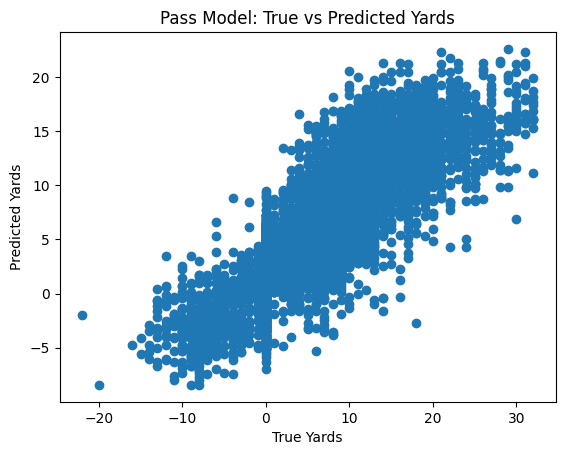

In [25]:
(x_train, x_test, y_train, y_test), (features, target) = prepare_model_data(0.1, True)
predictions = estimator.best_estimator_.predict(x_test)

visualize_predicts(y_test, predictions)

Random Forest

Run Model Mean Squared Error: 7.158222827732365
Pass Model Mean Squared Error: 10.92462361838278
Run Model Mean Absolute Error: 1.7735089312745986
Pass Model Mean Absolute Error: 2.1386852821407794
Run Model Root Mean Squared Error: 2.675485531213422
Pass Model Root Mean Squared Error: 3.305241839621237
Run Model Mean Squared Error: 7.158222827732365
Pass Model Mean Squared Error: 10.92462361838278


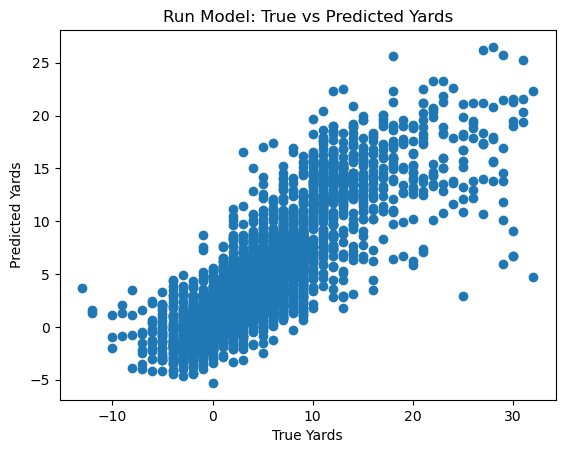

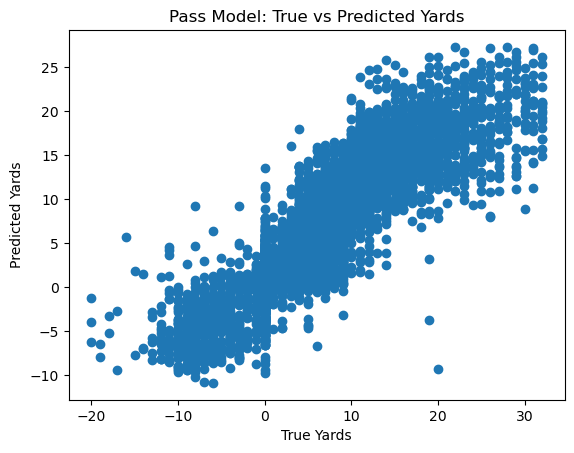

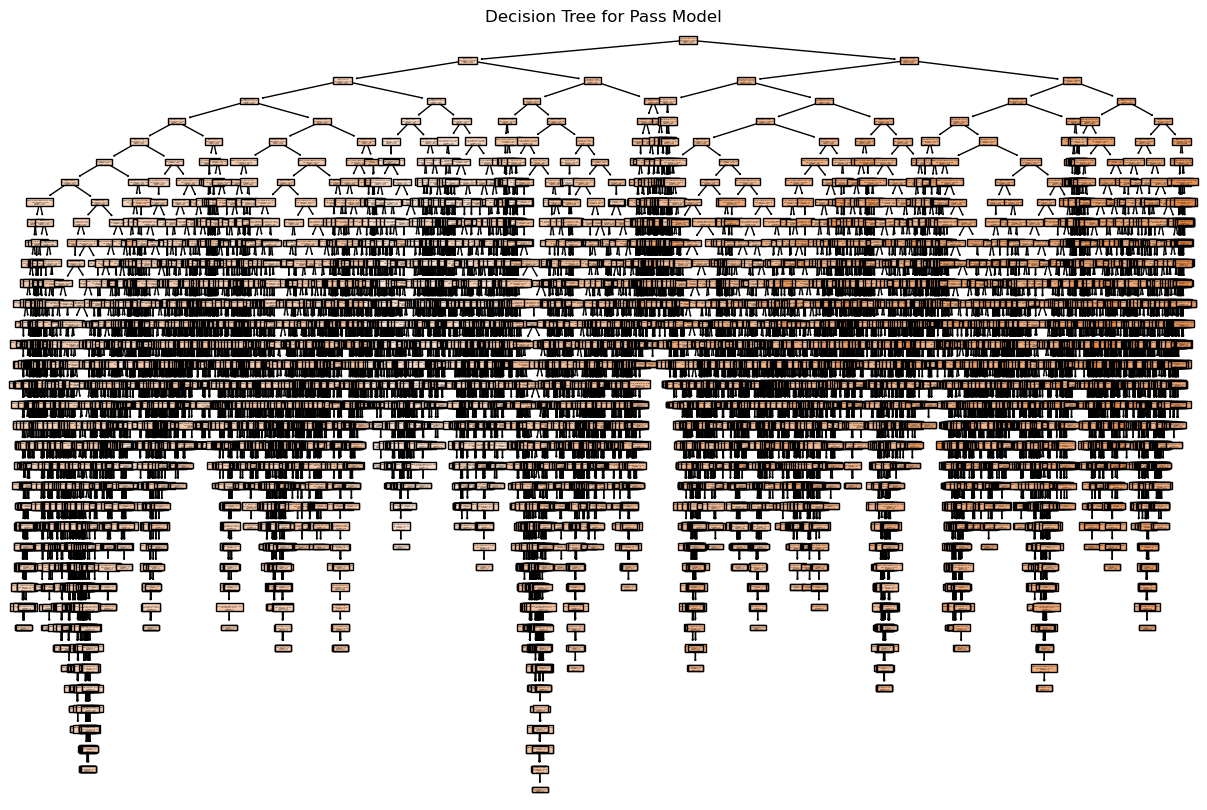

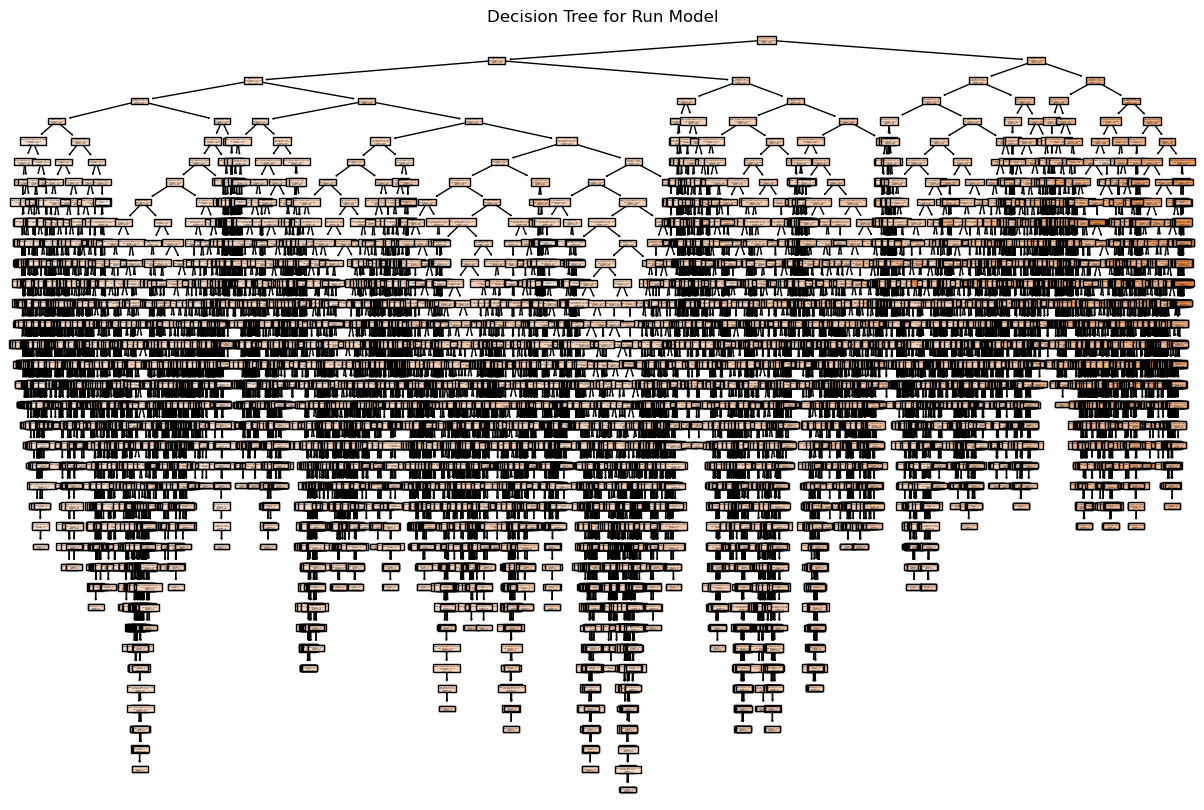

In [35]:
# Initialize the Random Forest regressor
pass_rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5) 
run_rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5) 

# Train the model
pass_rf_regressor.fit(pass_X_train, pass_y_train)
run_rf_regressor.fit(run_X_train, run_y_train)

# Make predictions on the test set
pass_predictions = pass_rf_regressor.predict(pass_X_test)
run_predictions = run_rf_regressor.predict(run_X_test)

# Evaluate the model
run_mse = mean_squared_error(run_y_test, run_predictions)
pass_mse = mean_squared_error(pass_y_test, pass_predictions)

run_rmse = mean_squared_error(run_y_test, run_predictions, squared = False)
pass_rmse = mean_squared_error(pass_y_test, pass_predictions, squared = False)

run_msa = mean_absolute_error(run_y_test, run_predictions)
pass_msa = mean_absolute_error(pass_y_test, pass_predictions)

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")
print(f"Run Model Mean Absolute Error: {run_msa}")
print(f"Pass Model Mean Absolute Error: {pass_msa}")
print(f"Run Model Root Mean Squared Error: {run_rmse}")
print(f"Pass Model Root Mean Squared Error: {pass_rmse}")

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")

# Visualize predictions for runs
plt.scatter(run_y_test, run_predictions)
plt.title('Run Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Visualize predictions for passes
plt.scatter(pass_y_test, pass_predictions)
plt.title('Pass Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plt.figure(figsize=(15, 10))
plot_tree(individual_tree_pass, filled=True, feature_names=pass_X_train.columns)
plt.title('Decision Tree for Pass Model')
plt.show()

# Plot the decision tree for runs
plt.figure(figsize=(15, 10))
plot_tree(individual_tree_run, filled=True, feature_names=run_X_train.columns)
plt.title('Decision Tree for Run Model')
plt.show()

# Cross-validation for runs
# run_cv_scores = cross_val_score(run_knn_regressor, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
# print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

# Cross-validation for passes
# pass_cv_scores = cross_val_score(pass_knn_regressor, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
# print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Artificial Neuronal Network

Epoch 1/100
826/826 [==============================] - 1s 537us/step - loss: 13.6800 - val_loss: 8.8073
Epoch 2/100
826/826 [==============================] - 0s 468us/step - loss: 8.8281 - val_loss: 8.3694
Epoch 3/100
826/826 [==============================] - 0s 477us/step - loss: 8.4708 - val_loss: 8.1625
Epoch 4/100
826/826 [==============================] - 0s 471us/step - loss: 8.3899 - val_loss: 8.0583
Epoch 5/100
826/826 [==============================] - 0s 475us/step - loss: 8.2469 - val_loss: 8.0055
Epoch 6/100
826/826 [==============================] - 0s 517us/step - loss: 8.1274 - val_loss: 7.9777
Epoch 7/100
826/826 [==============================] - 0s 481us/step - loss: 8.0689 - val_loss: 7.9130
Epoch 8/100
826/826 [==============================] - 0s 493us/step - loss: 7.9992 - val_loss: 7.9147
Epoch 9/100
826/826 [==============================] - 0s 491us/step - loss: 7.9711 - val_loss: 7.8696
Epoch 10/100
826/826 [==============================] - 0s 481us/step - 

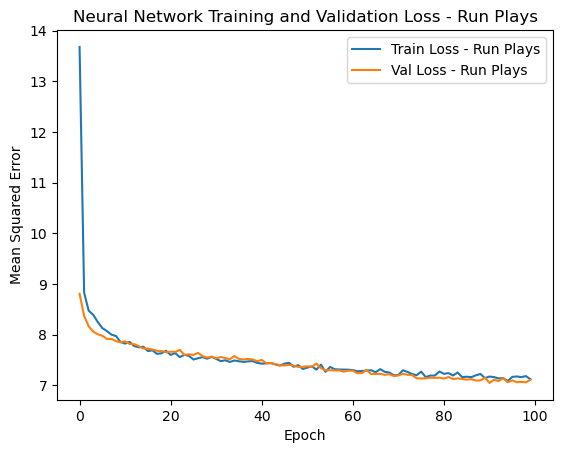

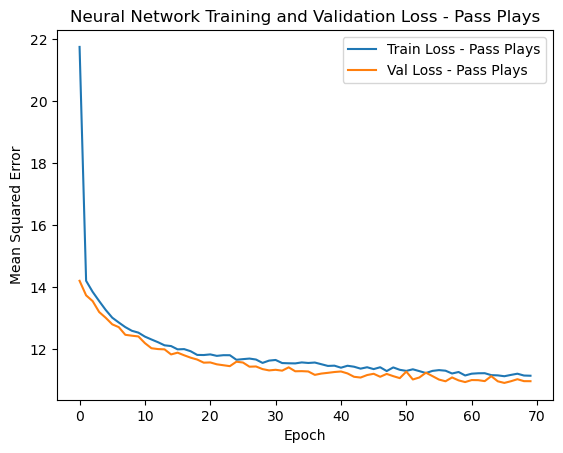

207/207 [==============================] - 0s 351us/step
Mean Squared Error (MSE) for run plays: 7.110485295641424
269/269 [==============================] - 0s 293us/step
Mean Squared Error (MSE) for pass plays: 10.970427046212873


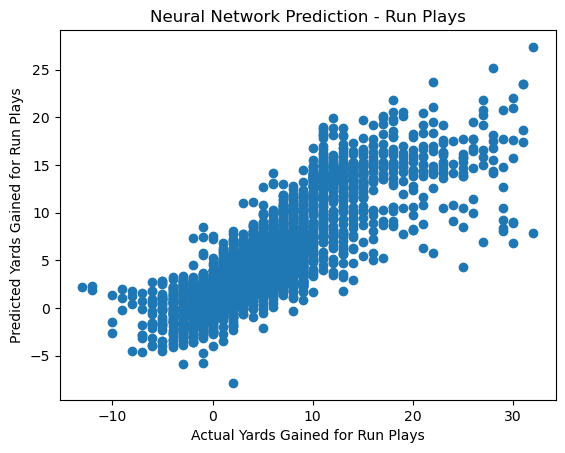

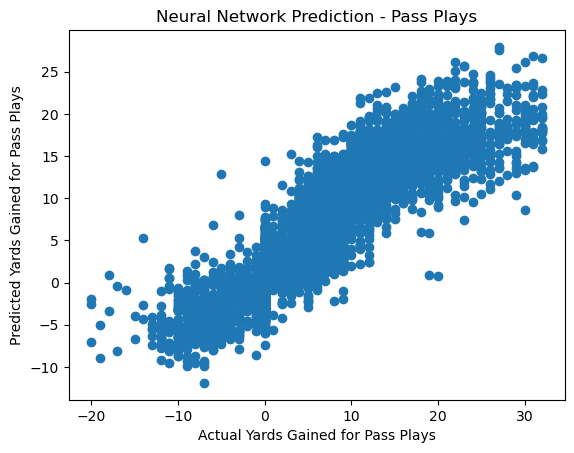

In [27]:


# Standardize the features
scaler_run = StandardScaler()
X_run_train_scaled = scaler_run.fit_transform(run_X_train)
X_run_test_scaled = scaler_run.transform(run_X_test)

scaler_pass = StandardScaler()
X_pass_train_scaled = scaler_pass.fit_transform(pass_X_train)
X_pass_test_scaled = scaler_pass.transform(pass_X_test)

# Build and train the neural network for run plays
model_run = Sequential()
model_run.add(Dense(64, input_dim=X_run_train_scaled.shape[1], activation='relu'))
# model_run.add(Dense(32, activation='relu'))
model_run.add(Dropout(0.2))
model_run.add(Dense(1, activation='linear'))

model_run.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history_run = model_run.fit(X_run_train_scaled, run_y_train, epochs=100, batch_size=32, validation_data=(X_run_test_scaled, run_y_test))

# Build and train the neural network for pass plays
model_pass = Sequential()
model_pass.add(Dense(64, input_dim=X_pass_train_scaled.shape[1], activation='relu'))
# model_pass.add(Dense(32, activation='relu'))
model_pass.add(Dropout(0.05))
model_pass.add(Dense(1, activation='linear'))

model_pass.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history_pass = model_pass.fit(X_pass_train_scaled, pass_y_train, epochs=70, batch_size=32, validation_data=(X_pass_test_scaled, pass_y_test))


# Plot the training and validation loss for run plays
plt.plot(history_run.history['loss'], label='Train Loss - Run Plays')
plt.plot(history_run.history['val_loss'], label='Val Loss - Run Plays')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network Training and Validation Loss - Run Plays')
plt.legend()
plt.show()

# Plot the training and validation loss for pass plays
plt.plot(history_pass.history['loss'], label='Train Loss - Pass Plays')
plt.plot(history_pass.history['val_loss'], label='Val Loss - Pass Plays')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network Training and Validation Loss - Pass Plays')
plt.legend()
plt.show()


# Evaluate the neural network for run plays
y_run_pred = model_run.predict(X_run_test_scaled)
mse_run = mean_squared_error(run_y_test, y_run_pred)
print(f"Mean Squared Error (MSE) for run plays: {mse_run}")

# Evaluate the neural network for pass plays
y_pass_pred = model_pass.predict(X_pass_test_scaled)
mse_pass = mean_squared_error(pass_y_test, y_pass_pred)
print(f"Mean Squared Error (MSE) for pass plays: {mse_pass}")

# Visualize predictions for run plays
plt.scatter(run_y_test, y_run_pred)
plt.xlabel('Actual Yards Gained for Run Plays')
plt.ylabel('Predicted Yards Gained for Run Plays')
plt.title('Neural Network Prediction - Run Plays')
plt.show()

# Visualize predictions for pass plays
plt.scatter(pass_y_test, y_pass_pred)
plt.xlabel('Actual Yards Gained for Pass Plays')
plt.ylabel('Predicted Yards Gained for Pass Plays')
plt.title('Neural Network Prediction - Pass Plays')
plt.show()
